In [21]:
%load_ext autoreload
%autoreload 2

In [1]:
# Built-in
import os
import time
from pathlib import Path

import matplotlib.pyplot as plt
# External
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Local
from adad.torch_utils import evaluate, train_model
from adad.utils import drop_redundant_col, maccs2binary, time2str


In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)


/home/lukec/workspace/applicabilityDomain


In [3]:
file_smiles = os.path.join(PATH_ROOT, "data", "smiles", "Ames_smiles.csv")
df = pd.read_csv(file_smiles)
y = df['y'].to_numpy()

file_x = os.path.join(PATH_ROOT, "data", "maccs", "Ames_maccs.npy")
X = np.load(file_x)

file_idx_train = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_train.csv")
file_idx_test = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_test.csv")
idx_train = pd.read_csv(file_idx_train, dtype=pd.Int64Dtype())
idx_test = pd.read_csv(file_idx_test, dtype=pd.Int64Dtype())
col = idx_train.columns[0]
idx_test = idx_test[col].dropna(axis=0).to_numpy().astype(int)
idx_train = idx_train[col].dropna(axis=0).to_numpy().astype(int)

X_train, X_test = X[idx_train], X[idx_test]
y_train, y_test = y[idx_train], y[idx_test]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5204, 167) (1302, 167)
(5204,) (1302,)


In [4]:
BATCH_SIZE = 128
MAX_EPOCHS = 300

dataset_train = TensorDataset(
    torch.from_numpy(X_train).type(torch.float32),
    torch.from_numpy(y_train).type(torch.int64),
)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(
    torch.from_numpy(X_test).type(torch.float32),
    torch.from_numpy(y_test).type(torch.int64),
)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print('Running on CPU!')

In [6]:
# class AutoEncoder(nn.Module):
#     def __init__(self, n_output=N_OUTPUT):
#         super().__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(167, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, n_output),
#         )

#         self.decoder = nn.Sequential(
#             nn.Linear(n_output, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, 167),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [7]:
N_OUTPUT = 16

class Reshape(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels
    
    def forward(self, x):
        x = torch.reshape(x, (x.size(0), self.n_channels, -1))
        return x


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            Reshape(1),
            nn.Conv1d(1, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(1312, 128),
            nn.ReLU(),
            nn.Linear(128, N_OUTPUT),
        )

        self.decoder = nn.Sequential(
            nn.Linear(N_OUTPUT, 128),
            nn.ReLU(),
            nn.Linear(128, 1312),
            nn.ReLU(),
            Reshape(32),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2),
            nn.Sigmoid(),
            nn.Flatten(1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


ae = AutoEncoder()
it = iter(dataloader_train)
x, y = it.next()
print(x.size())
output = ae(x)
print(output.size())

torch.Size([128, 167])
torch.Size([128, 167])


In [8]:
def train(dataloader, model, loss_fn, optimizer, device):
    n = len(dataloader.dataset)
    n_batches = len(dataloader)
    loss_avg = 0

    model.train()
    for X, _ in dataloader:
        X = X.to(device)

        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, X)
        loss.backward()
        optimizer.step()

        loss_avg += loss.item()

    loss_avg /= n_batches
    return loss_avg


def evaluate(dataloader, model, loss_fn, device):
    n = len(dataloader.dataset)
    n_batches = len(dataloader)
    loss_avg = 0

    model.eval()
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            output = model(X)
            loss_avg += loss_fn(output, X).item()

    loss_avg /= n_batches
    return loss_avg

In [9]:
model = AutoEncoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [10]:
MAX_EPOCHS = 200

losses_tr = []
losses_te = []

# for e in tqdm(range(MAX_EPOCHS)):
for e in range(MAX_EPOCHS):
    loss_tr = train(dataloader_train, model, loss_fn, optimizer, device)
    loss_te = evaluate(dataloader_test, model, loss_fn, device)

    losses_tr.append(loss_tr)
    losses_te.append(loss_te)

    if e // 10 == 0:
        print(f'[{e:3d}] Loss train: {loss_tr:.3f} test: {loss_te:.3f}')
print(f'Train {loss_tr:.3f} Test {loss_te:.3f}')

[  0] Loss train: 0.236 test: 0.223
[  1] Loss train: 0.193 test: 0.154
[  2] Loss train: 0.133 test: 0.125
[  3] Loss train: 0.122 test: 0.122
[  4] Loss train: 0.120 test: 0.120
[  5] Loss train: 0.119 test: 0.120
[  6] Loss train: 0.118 test: 0.119
[  7] Loss train: 0.117 test: 0.117
[  8] Loss train: 0.116 test: 0.116
[  9] Loss train: 0.115 test: 0.114
Train 0.011 Test 0.016


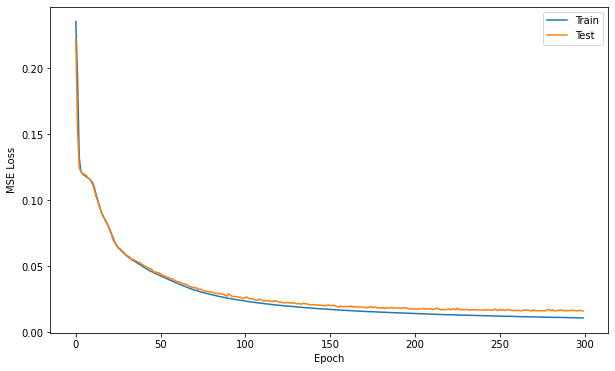

In [11]:
plt.figure(figsize=(10, 6))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.plot(losses_tr, label='Train')
plt.plot(losses_te, label='Test')
plt.legend()
plt.show()

In [12]:
def encode(X, model, n_outputs, batch_size=256):
    n = X.shape[0]
    dataset = TensorDataset(torch.from_numpy(X).type(torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    X_encoded = np.empty((n, n_outputs), dtype=np.float32)
    start = 0
    model.eval()
    with torch.no_grad():
        for [X] in dataloader:
            X = X.to(device)
            output = model.encoder(X).detach().cpu().numpy()
            end = start + X.size(0)
            X_encoded[start: end] = output
            start = end
    return X_encoded


In [13]:
def encodedecode(X, model, batch_size=256):
    dataset = TensorDataset(torch.from_numpy(X).type(torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    X_processed = np.empty_like(X)
    start = 0
    model.eval()
    with torch.no_grad():
        for [X] in dataloader:
            X = X.to(device)
            output = model(X).detach().cpu().numpy()
            end = start + X.size(0)
            X_processed[start: end] = output
            start = end
    return X_processed

In [14]:
X_encode_tr = encode(X_train, model, N_OUTPUT)
X_encode_te = encode(X_test, model, N_OUTPUT)
print(X_encode_tr.shape, X_encode_te.shape)

(5204, 16) (1302, 16)


In [15]:
X_process_tr = encodedecode(X_train, model)
X_process_te = encodedecode(X_test, model)
print(X_process_tr.shape, X_process_te.shape)

(5204, 167) (1302, 167)


In [16]:
from sklearn.svm import SVC

clf = SVC(C=10)
clf.fit(X_train, y_train)

acc_train = clf.score(X_train, y_train)
acc_test = clf.score(X_test, y_test)
print(f'Accuracy train: {acc_train*100:.2f}% test: {acc_test*100:.2f}%')

Accuracy train: 93.97% test: 81.57%


In [17]:
clf = SVC(C=10)
clf.fit(X_encode_tr, y_train)

acc_train = clf.score(X_encode_tr, y_train)
acc_test = clf.score(X_encode_te, y_test)
print(f'Accuracy train: {acc_train*100:.2f}% test: {acc_test*100:.2f}%')

Accuracy train: 77.40% test: 74.96%


In [18]:
clf = SVC(C=10)
clf.fit(X_process_tr, y_train)

acc_train = clf.score(X_process_tr, y_train)
acc_test = clf.score(X_process_te, y_test)
print(f'Accuracy train: {acc_train*100:.2f}% test: {acc_test*100:.2f}%')

Accuracy train: 83.21% test: 73.50%
